# REINVENT4 LibInvent - NVIDIA DGX Spark (Baseline)
## DENV NS2B-NS3 Protease Inhibitor Generation

**Hardware**: NVIDIA DGX Spark (128GB unified memory, GB10 GPU, 20 CPU cores)

**实验设计**: Baseline - 建立稳定参考线

| 参数 | 值 | 理由 |
|------|-----|------|
| batch_size | 64 | 减少CPU瓶颈，提高GPU利用率 |
| sigma | 100 | 平衡探索与收敛 |
| rate | 0.0002 | 稳定学习 |
| bucket_size | 20 | 适度多样性压力 |

---

### TensorBoard 实时监控
```bash
# 在另一个终端运行：
tensorboard --logdir experiments/runs/baseline_run1/tensorboard --bind_all --port 6006
```
然后访问 http://<spark-ip>:6006

---

In [27]:
# Cell 1: 环境检查和导入
import os
import sys
import subprocess
import threading
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

print("=" * 80)
print("REINVENT4 LibInvent - DGX Spark Baseline")
print("=" * 80)
print(f"\n时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python版本: {sys.version.split()[0]}")
print(f"工作目录: {os.getcwd()}")

# 检查CUDA
try:
    import torch
    print(f"\nPyTorch版本: {torch.__version__}")
    print(f"CUDA可用: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA版本: {torch.version.cuda}")
        print(f"GPU设备: {torch.cuda.get_device_name(0)}")
        total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
        free_mem = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9
        print(f"GPU内存: {total_mem:.1f} GB total, ~{free_mem:.1f} GB free")
except Exception as e:
    print(f"\n⚠️ PyTorch检查失败: {e}")

# 检查CPU
cpu_count = os.cpu_count()
print(f"\nCPU核心数: {cpu_count}")

print("\n✅ 环境检查完成")

REINVENT4 LibInvent - DGX Spark Baseline

时间: 2025-12-02 11:05:17
Python版本: 3.10.16
工作目录: /home/august/aidd/DENV_Drug_Discovery

PyTorch版本: 2.9.1+cu130
CUDA可用: True
CUDA版本: 13.0
GPU设备: NVIDIA GB10
GPU内存: 128.5 GB total, ~128.5 GB free

CPU核心数: 20

✅ 环境检查完成


In [28]:
# Cell 2: 路径配置
REINVENT_HOME = Path.home() / "aidd" / "DENV_Drug_Discovery"
EXP_NAME = "baseline_run2"
EXP_DIR = REINVENT_HOME / "experiments" / "runs" / EXP_NAME

print("路径配置:")
print(f"  REINVENT根目录: {REINVENT_HOME}")
print(f"  实验目录: {EXP_DIR}")

# 创建实验目录
EXP_DIR.mkdir(parents=True, exist_ok=True)
(EXP_DIR / "tensorboard").mkdir(exist_ok=True)
print(f"\n✅ 实验目录已创建: {EXP_DIR}")

路径配置:
  REINVENT根目录: /home/august/aidd/DENV_Drug_Discovery
  实验目录: /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2

✅ 实验目录已创建: /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2


In [29]:
# Cell 3: 文件完整性检查
print("检查必需文件...\n")

required_files = {
    "Prior模型": REINVENT_HOME / "priors" / "libinvent.prior",
    "Agent模型": REINVENT_HOME / "priors" / "denv_libinvent_model_v2.model",
    "Scaffold文件": REINVENT_HOME / "data" / "pyrrolidine_dual_aryl.smi",
    "QSAR模型": REINVENT_HOME / "models" / "random_forest_champion.joblib",
    "QSAR插件": REINVENT_HOME / "reinvent_plugins" / "components" / "comp_qsar_scorer.py",
}

all_exists = True
for name, path in required_files.items():
    exists = path.exists()
    status = "✅" if exists else "❌"
    print(f"{status} {name}: {path}")
    if not exists:
        all_exists = False

if all_exists:
    print("\n✅ 所有必需文件检查通过")
else:
    raise FileNotFoundError("缺少必需文件")

检查必需文件...

✅ Prior模型: /home/august/aidd/DENV_Drug_Discovery/priors/libinvent.prior
✅ Agent模型: /home/august/aidd/DENV_Drug_Discovery/priors/denv_libinvent_model_v2.model
✅ Scaffold文件: /home/august/aidd/DENV_Drug_Discovery/data/pyrrolidine_dual_aryl.smi
✅ QSAR模型: /home/august/aidd/DENV_Drug_Discovery/models/random_forest_champion.joblib
✅ QSAR插件: /home/august/aidd/DENV_Drug_Discovery/reinvent_plugins/components/comp_qsar_scorer.py

✅ 所有必需文件检查通过


In [35]:
# Cell 4: Scaffold诊断 - 关键！
print("=" * 80)
print("Scaffold诊断")
print("=" * 80)

from rdkit import Chem

scaffold_file = REINVENT_HOME / "data" / "pyrrolidine_dual_aryl.smi"
with open(scaffold_file) as f:
    scaffolds = [line.strip().split()[0] for line in f if line.strip() and not line.startswith('#')]

print(f"\n共 {len(scaffolds)} 个scaffolds:\n")

valid_count = 0
attachment_stats = {}

for i, smi in enumerate(scaffolds):
    # 统计attachment points
    n_attach = smi.count('[*]')
    attachment_stats[n_attach] = attachment_stats.get(n_attach, 0) + 1
    
    # 验证SMILES
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_count += 1
        status = "✓"
    else:
        status = "✗ INVALID"
    
    # 截断显示
    display_smi = smi[:55] + "..." if len(smi) > 55 else smi
    print(f"  {i+1:2d}. [{n_attach}个连接点] {status} {display_smi}")

print(f"\n统计:")
print(f"  有效scaffolds: {valid_count}/{len(scaffolds)}")
print(f"  连接点分布: {attachment_stats}")

if valid_count < len(scaffolds):
    print("\n⚠️ 警告: 存在无效scaffold，可能导致高invalid率！")
else:
    print("\n✅ 所有scaffolds有效")

Scaffold诊断

共 16 个scaffolds:

   1. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2ccccc2)C(C(=O)N[*:3])C1
   2. [0个连接点] ✓ c1ccc([*:1])cc1C1N([*:4])C(c2ccccc2)C(C(=O)N[*:3])C1
   3. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2ccc([*:2])cc2)C(C(=O)N[*:3])C1
   4. [0个连接点] ✓ c1ccc([*:1])cc1C1N([*:4])C(c2ccc([*:2])cc2)C(C(=O)N[*:3...
   5. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2ccncc2)C(C(=O)N[*:3])C1
   6. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2cccnc2)C(C(=O)N[*:3])C1
   7. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2ncccc2)C(C(=O)N[*:3])C1
   8. [0个连接点] ✓ c1ccncc1C1N([*:4])C(c2ccccc2)C(C(=O)N[*:3])C1
   9. [0个连接点] ✓ c1ccncc1C1N([*:4])C(c2ccncc2)C(C(=O)N[*:3])C1
  10. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2cccs2)C(C(=O)N[*:3])C1
  11. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2sccc2)C(C(=O)N[*:3])C1
  12. [0个连接点] ✓ c1ccsc1C1N([*:4])C(c2ccccc2)C(C(=O)N[*:3])C1
  13. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2ccco2)C(C(=O)N[*:3])C1
  14. [0个连接点] ✓ c1ccoc1C1N([*:4])C(c2ccccc2)C(C(=O)N[*:3])C1
  15. [0个连接点] ✓ c1ccccc1C1N([*:4])C(c2cccc3ccccc23)C(C(=O)N[*:3])C1
  16. [0个连接点

In [41]:
# Cell 5: 生成优化配置文件 (Baseline)
print("=" * 80)
print("生成Baseline配置")
print("=" * 80)

# ============================================
# 核心参数 - Baseline配置
# ============================================
BATCH_SIZE = 64        # ↓ 从512降至64，减少CPU瓶颈
SIGMA =200             # 平衡探索与收敛
LEARNING_RATE = 0.0002  # 稳定学习率
BUCKET_SIZE = 20        # 适度多样性
MIN_SCORE = 0.4         # ↓ 从0.6降至0.4，初期允许探索
MIN_STEPS = 500        # 最小步数
MAX_STEPS = 1000        # 最大步数 (64×4000=512K分子)
MEMORY_SIZE = 50        # ↓ 从100降至50
SAMPLE_SIZE = 10        # ↓ 从20降至10

config_content = f'''# REINVENT4 LibInvent - Baseline Configuration
# Generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
# 
# 参数理论依据:
#   batch_size=64: 减少CPU SMILES处理瓶颈，提高GPU利用率
#   sigma=200: DAP公式 augmented_nlls = agent_nlls + sigma*(1-scores)
#              更高sigma增强探索，防止早熟收敛
#   rate=0.0002: 与较小batch配合，保持稳定的有效学习率
#   bucket_size=20: 每个Murcko scaffold允许20个变体后才惩罚

run_type = "staged_learning"
device = "cuda:0"
tb_logdir = "experiments/runs/{EXP_NAME}/tensorboard"
json_out_config = "experiments/runs/{EXP_NAME}/_config.json"

[parameters]
summary_csv_prefix = "experiments/runs/{EXP_NAME}/results"
use_checkpoint = true
purge_memories = false

prior_file = "experiments/runs/{EXP_NAME}/checkpoint.chkpt"
agent_file = "priors/denv_libinvent_model_v2.model"
smiles_file = "data/pyrrolidine_dual_aryl.smi"

# ============================================
# 优化参数 - 针对DGX Spark
# ============================================
batch_size = {BATCH_SIZE}
unique_sequences = true
randomize_smiles = false

[learning_strategy]
type = "dap"
sigma = {SIGMA}
rate = {LEARNING_RATE}

[diversity_filter]
type = "IdenticalMurckoScaffold"
bucket_size = {BUCKET_SIZE}
minscore = {MIN_SCORE}

[inception]
smiles_file = "data/pyrrolidine_dual_aryl.smi"
memory_size = {MEMORY_SIZE}
sample_size = {SAMPLE_SIZE}

# ============================================
# Stage 1: 主训练阶段
# ============================================
[[stage]]
max_score = 0.85
min_steps = {MIN_STEPS}
max_steps = {MAX_STEPS}
chkpt_file = "experiments/runs/{EXP_NAME}/checkpoint.chkpt"

[stage.scoring]
type = "arithmetic_mean"

# ========================================
# 第一优先级：QSAR活性预测 (权重3.0)
# ========================================
[[stage.scoring.component]]
[stage.scoring.component.QSARScorer]
[[stage.scoring.component.QSARScorer.endpoint]]
name = "DENV_Activity"
weight = 3.0

[stage.scoring.component.QSARScorer.endpoint.params]
model_path = "models/random_forest_champion.joblib"

[stage.scoring.component.QSARScorer.endpoint.transform]
type = "double_sigmoid"
low = 4.5
high = 9.0
coef_div = 9.0
coef_si = 8.0
coef_se = 8.0

# ========================================
# 第二优先级：化学稳定性
# ========================================
[[stage.scoring.component]]
[stage.scoring.component.NumAtomStereoCenters]
[[stage.scoring.component.NumAtomStereoCenters.endpoint]]
name = "Stereo_Centers"
weight = 0.6

[stage.scoring.component.NumAtomStereoCenters.endpoint.transform]
type = "reverse_sigmoid"
low = 0
high = 3
k = 1.0

[[stage.scoring.component]]
[stage.scoring.component.CustomAlerts]
[[stage.scoring.component.CustomAlerts.endpoint]]
name = "Stability_Alerts"
weight = 1.2

[stage.scoring.component.CustomAlerts.endpoint.params]
smarts = [
    "[*;r8]", "[*;r9]", "[*;r10]",
    "[#8][#8]",
    "[#6;+]",
    "C#C",
    "[NX3][NX3]",
    "[SH]",
    "[N+](=O)[O-]",
    "S(=O)(=O)Cl",
    "[F,Cl,Br,I][C,c][F,Cl,Br,I]",
]

# ========================================
# 第三优先级：类药性
# ========================================
[[stage.scoring.component]]
[stage.scoring.component.Qed]
[[stage.scoring.component.Qed.endpoint]]
name = "QED"
weight = 0.4

[[stage.scoring.component]]
[stage.scoring.component.SAScore]
[[stage.scoring.component.SAScore.endpoint]]
name = "SA"
weight = 0.5

[stage.scoring.component.SAScore.endpoint.transform]
type = "reverse_sigmoid"
low = 1.0
high = 5.5
k = 0.8

# ========================================
# 第四优先级：物理化学性质
# ========================================
[[stage.scoring.component]]
[stage.scoring.component.MolecularWeight]
[[stage.scoring.component.MolecularWeight.endpoint]]
name = "MW"
weight = 0.5

[stage.scoring.component.MolecularWeight.endpoint.transform]
type = "double_sigmoid"
low = 280.0
high = 550.0
coef_div = 550.0
coef_si = 15.0
coef_se = 15.0

[[stage.scoring.component]]
[stage.scoring.component.SlogP]
[[stage.scoring.component.SlogP.endpoint]]
name = "LogP"
weight = 0.4

[stage.scoring.component.SlogP.endpoint.transform]
type = "double_sigmoid"
low = 1.0
high = 4.5
coef_div = 4.5
coef_si = 10.0
coef_se = 10.0

[[stage.scoring.component]]
[stage.scoring.component.TPSA]
[[stage.scoring.component.TPSA.endpoint]]
name = "TPSA"
weight = 0.3

[stage.scoring.component.TPSA.endpoint.transform]
type = "double_sigmoid"
low = 40.0
high = 120.0
coef_div = 120.0
coef_si = 15.0
coef_se = 15.0

[[stage.scoring.component]]
[stage.scoring.component.HBondAcceptors]
[[stage.scoring.component.HBondAcceptors.endpoint]]
name = "HBA"
weight = 0.3

[stage.scoring.component.HBondAcceptors.endpoint.transform]
type = "reverse_sigmoid"
low = 2
high = 8
k = 0.5

[[stage.scoring.component]]
[stage.scoring.component.HBondDonors]
[[stage.scoring.component.HBondDonors.endpoint]]
name = "HBD"
weight = 0.2

[stage.scoring.component.HBondDonors.endpoint.transform]
type = "reverse_sigmoid"
low = 0
high = 4
k = 0.5

[[stage.scoring.component]]
[stage.scoring.component.NumRotBond]
[[stage.scoring.component.NumRotBond.endpoint]]
name = "Rotatable_Bonds"
weight = 0.2

[stage.scoring.component.NumRotBond.endpoint.transform]
type = "reverse_sigmoid"
low = 0
high = 8
k = 0.5

[[stage.scoring.component]]
[stage.scoring.component.NumRings]
[[stage.scoring.component.NumRings.endpoint]]
name = "Ring_Count"
weight = 0.2

[stage.scoring.component.NumRings.endpoint.transform]
type = "reverse_sigmoid"
low = 2
high = 5
k = 0.5

# ========================================
# 第五优先级：毒性过滤（精简版）
# ========================================
[[stage.scoring.component]]
[stage.scoring.component.CustomAlerts]
[[stage.scoring.component.CustomAlerts.endpoint]]
name = "Toxicity_Alerts"
weight = 1.2

[stage.scoring.component.CustomAlerts.endpoint.params]
smarts = [
    "N=N",
    "[N;R0]=[N;R0][#6]",
    "C(=O)Cl",
    "[#6]OO[#6]",
    "C(=O)C(=O)",
    "[Cl,Br,I][#6][Cl,Br,I]",
]

[[stage.scoring.component]]
[stage.scoring.component.CustomAlerts]
[[stage.scoring.component.CustomAlerts.endpoint]]
name = "PAINS_Filter"
weight = 0.8

[stage.scoring.component.CustomAlerts.endpoint.params]
smarts = [
    "O=C1C=CC(=O)C=C1",
    "[OH]c1ccccc1[OH]",
    "c1ccc2c(c1)[nH]c1ccccc12",
]
'''

config_path = EXP_DIR / "config.toml"
with open(config_path, 'w') as f:
    f.write(config_content)

print(f"\n✅ 配置文件已生成: {config_path}")
print(f"\n" + "=" * 50)
print("Baseline配置摘要:")
print("=" * 50)
print(f"  batch_size:    {BATCH_SIZE:>6}  (↓ 从512优化)")
print(f"  sigma:         {SIGMA:>6}  (探索强度)")
print(f"  learning_rate: {LEARNING_RATE:>6}")
print(f"  bucket_size:   {BUCKET_SIZE:>6}")
print(f"  min_score:     {MIN_SCORE:>6}  (↓ 允许更多探索)")
print(f"  max_steps:     {MAX_STEPS:>6}")
print(f"\n  预期分子数:    ~{BATCH_SIZE * MAX_STEPS:,}")
print(f"  Scoring组件:   12个 (精简版)")

生成Baseline配置

✅ 配置文件已生成: /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2/config.toml

Baseline配置摘要:
  batch_size:        64  (↓ 从512优化)
  sigma:            200  (探索强度)
  learning_rate: 0.0002
  bucket_size:       20
  min_score:        0.4  (↓ 允许更多探索)
  max_steps:       1000

  预期分子数:    ~64,000
  Scoring组件:   12个 (精简版)


In [42]:
# Cell 6: TensorBoard启动指南
print("=" * 80)
print("TensorBoard 实时监控设置")
print("=" * 80)

tb_logdir = EXP_DIR / "tensorboard"

print(f"""
┌────────────────────────────────────────────────────────────────┐
│  在另一个终端窗口运行以下命令启动TensorBoard:                    │
├────────────────────────────────────────────────────────────────┤
│                                                                │
│  cd {REINVENT_HOME}
│  tensorboard --logdir {tb_logdir.relative_to(REINVENT_HOME)} --bind_all --port 6007
│                                                                │
├────────────────────────────────────────────────────────────────┤
│  然后在浏览器访问:                                              │
│    http://<spark-hostname>:6007                                │
│  或者本地:                                                      │
│    http://localhost:6007                                       │
├────────────────────────────────────────────────────────────────┤
│  TensorBoard将显示:                                            │
│    • Score曲线 (total_score, DENV_Activity等)                  │
│    • NLL曲线 (Agent, Prior)                                    │
│    • Valid率                                                   │
│    • 学习进度                                                  │
└────────────────────────────────────────────────────────────────┘
""")

# 可选：自动启动TensorBoard（后台）
start_tb = input("是否现在启动TensorBoard后台进程? (y/n): ").strip().lower()
if start_tb == 'y':
    tb_cmd = f"nohup tensorboard --logdir {tb_logdir} --bind_all --port 6007 > {EXP_DIR}/tensorboard.log 2>&1 &"
    os.system(tb_cmd)
    print("\n✅ TensorBoard已在后台启动 (端口6007)")
    print(f"   日志: {EXP_DIR}/tensorboard.log")
else:
    print("\n跳过TensorBoard启动，可稍后手动启动")

TensorBoard 实时监控设置

┌────────────────────────────────────────────────────────────────┐
│  在另一个终端窗口运行以下命令启动TensorBoard:                    │
├────────────────────────────────────────────────────────────────┤
│                                                                │
│  cd /home/august/aidd/DENV_Drug_Discovery
│  tensorboard --logdir experiments/runs/baseline_run2/tensorboard --bind_all --port 6007
│                                                                │
├────────────────────────────────────────────────────────────────┤
│  然后在浏览器访问:                                              │
│    http://<spark-hostname>:6007                                │
│  或者本地:                                                      │
│    http://localhost:6007                                       │
├────────────────────────────────────────────────────────────────┤
│  TensorBoard将显示:                                            │
│    • Score曲线 (total_score, DENV_Activity等)                  │
│    

是否现在启动TensorBoard后台进程? (y/n):  y



✅ TensorBoard已在后台启动 (端口6007)
   日志: /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2/tensorboard.log


In [43]:
# Cell 7: 资源监控工具
print("=" * 80)
print("资源监控工具")
print("=" * 80)

def get_gpu_usage():
    """获取GPU使用情况"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        if result.returncode == 0:
            parts = result.stdout.strip().split(', ')
            return {
                'gpu_util': float(parts[0]),
                'mem_used': float(parts[1]) / 1024,  # GB
                'mem_total': float(parts[2]) / 1024  # GB
            }
    except:
        pass
    return None

def get_cpu_usage():
    """获取CPU使用情况"""
    try:
        result = subprocess.run(['cat', '/proc/loadavg'], capture_output=True, text=True)
        if result.returncode == 0:
            load = float(result.stdout.split()[0])
            return load / os.cpu_count() * 100
    except:
        pass
    return None

# 显示当前状态
gpu_info = get_gpu_usage()
cpu_usage = get_cpu_usage()

if gpu_info:
    print(f"\nGPU状态:")
    print(f"  利用率: {gpu_info['gpu_util']:.1f}%")
    print(f"  内存:   {gpu_info['mem_used']:.1f} / {gpu_info['mem_total']:.1f} GB")

if cpu_usage:
    print(f"\nCPU负载: {cpu_usage:.1f}%")

print("\n✅ 监控工具就绪")

资源监控工具

CPU负载: 8.0%

✅ 监控工具就绪


In [ ]:
# Cell 8: 启动REINVENT4训练
print("=" * 80)
print("启动REINVENT4训练 - Baseline")
print("=" * 80)

start_time = datetime.now()
print(f"\n开始时间: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n预计生成分子: ~{BATCH_SIZE * MAX_STEPS:,}")
print(f"预计运行时间: 3-5 小时\n")

# 切换到REINVENT目录
os.chdir(REINVENT_HOME)
print(f"当前目录: {os.getcwd()}\n")

# 准备命令
config_rel_path = config_path.relative_to(REINVENT_HOME)
log_path = EXP_DIR / "training.log"

cmd = f"reinvent {config_rel_path}"
print(f"执行命令: {cmd}")
print(f"日志文件: {log_path}\n")
print("=" * 80)
print("训练开始... (输出将实时显示)")
print("=" * 80)
print()

# 执行训练（实时输出）
with open(log_path, 'w') as log_file:
    process = subprocess.Popen(
        cmd,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    
    step_count = 0
    for line in process.stdout:
        log_file.write(line)
        log_file.flush()
        
        # 只显示关键信息
        if 'Score:' in line or 'INFO' in line or 'WARN' in line or 'ERROR' in line or 'CRIT' in line:
            print(line.rstrip())
            
            # 统计步数
            if 'Score:' in line and 'Step:' in line:
                step_count += 1
                if step_count % 100 == 0:
                    elapsed = (datetime.now() - start_time).total_seconds() / 60
                    rate = step_count / elapsed if elapsed > 0 else 0
                    eta = (MAX_STEPS - step_count) / rate if rate > 0 else 0
                    print(f"\n--- 进度: {step_count}/{MAX_STEPS} steps, {elapsed:.1f}分钟已过, 预计还需{eta:.1f}分钟 ---\n")
    
    process.wait()

end_time = datetime.now()
duration = (end_time - start_time).total_seconds() / 60

print("\n" + "=" * 80)
if process.returncode == 0:
    print(f"✅ 训练完成！")
else:
    print(f"❌ 训练失败 (返回码: {process.returncode})")
print("=" * 80)
print(f"\n结束时间: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"总用时: {duration:.1f} 分钟")

启动REINVENT4训练 - Baseline

开始时间: 2025-12-02 11:11:24

预计生成分子: ~64,000
预计运行时间: 3-5 小时

当前目录: /home/august/aidd/DENV_Drug_Discovery

执行命令: reinvent experiments/runs/baseline_run2/config.toml
日志文件: /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2/training.log

训练开始... (输出将实时显示)

11:11:28 <INFO> Started REINVENT 4.6.27 (C) AstraZeneca 2017, 2023 on 2025-12-02
11:11:28 <INFO> Command line: /home/august/miniconda3/envs/reinvent4/bin/reinvent experiments/runs/baseline_run2/config.toml
11:11:28 <INFO> Reading run configuration from /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2/config.toml using format toml
11:11:28 <INFO> User august on host spark-a92c
11:11:28 <INFO> Python version 3.10.16
11:11:28 <INFO> PyTorch version 2.9.1+cu130, git 5811a8d7da873dd699ff6687092c225caffcf1bb
11:11:28 <INFO> PyTorch compiled with CUDA version 13.0
11:11:28 <INFO> RDKit version 2025.09.1
11:11:28 <INFO> Platform Linux-6.14.0-1013-nvidia-aarch64-with-glibc2.39
11:11:2

In [23]:
# Cell 9: 结果分析
print("=" * 80)
print("结果分析")
print("=" * 80)

# 查找结果CSV文件
csv_files = sorted(EXP_DIR.glob("results_*.csv"))

if not csv_files:
    print("\n❌ 未找到结果CSV文件")
else:
    csv_file = csv_files[0]
    print(f"\n加载结果文件: {csv_file.name}")
    
    try:
        df = pd.read_csv(csv_file)
        print(f"\n数据维度: {df.shape}")
        print(f"总生成分子数: {len(df):,}")
        
        # 基本统计
        print("\n" + "-" * 50)
        print("SMILES有效性统计")
        print("-" * 50)
        
        if 'SMILES_state' in df.columns:
            valid = df[df['SMILES_state'] == 1]
            invalid = df[df['SMILES_state'] == 0]
            duplicates = df[df['SMILES_state'] == 2]
            
            print(f"  Valid:      {len(valid):>8,} ({len(valid)/len(df)*100:>5.1f}%)")
            print(f"  Invalid:    {len(invalid):>8,} ({len(invalid)/len(df)*100:>5.1f}%)")
            print(f"  Duplicates: {len(duplicates):>8,} ({len(duplicates)/len(df)*100:>5.1f}%)")
        
        if 'SMILES' in df.columns:
            unique_smiles = df['SMILES'].nunique()
            print(f"  Unique:     {unique_smiles:>8,} ({unique_smiles/len(df)*100:>5.1f}%)")
        
        # 分数统计
        print("\n" + "-" * 50)
        print("Score统计")
        print("-" * 50)
        
        score_cols = ['total_score', 'DENV_Activity', 'QED', 'SA']
        for col in score_cols:
            if col in df.columns:
                print(f"  {col:20s}: {df[col].mean():>6.3f} ± {df[col].std():.3f}  (max: {df[col].max():.3f})")
        
        # 高分分子统计
        print("\n" + "-" * 50)
        print("高分分子统计")
        print("-" * 50)
        
        if 'total_score' in df.columns:
            for threshold in [0.5, 0.6, 0.7, 0.8]:
                count = len(df[df['total_score'] >= threshold])
                print(f"  Score ≥ {threshold}: {count:>8,}")
        
        if 'DENV_Activity' in df.columns:
            for threshold in [6.0, 7.0, 7.5, 8.0]:
                count = len(df[df['DENV_Activity'] >= threshold])
                print(f"  pIC50 ≥ {threshold}: {count:>8,}")
                
    except Exception as e:
        print(f"\n⚠️ 读取CSV失败: {e}")
        print("可能训练未正常完成，请检查日志文件")

结果分析

加载结果文件: results_1.csv

数据维度: (511556, 41)
总生成分子数: 511,556

--------------------------------------------------
SMILES有效性统计
--------------------------------------------------
  Valid:       507,068 ( 99.1%)
  Invalid:       3,440 (  0.7%)
  Duplicates:    1,048 (  0.2%)
  Unique:      492,388 ( 96.3%)

--------------------------------------------------
Score统计
--------------------------------------------------
  DENV_Activity       :  0.926 ± 0.109  (max: 0.965)
  QED                 :  0.526 ± 0.147  (max: 0.948)
  SA                  :  0.097 ± 0.085  (max: 0.756)

--------------------------------------------------
高分分子统计
--------------------------------------------------
  pIC50 ≥ 6.0:        0
  pIC50 ≥ 7.0:        0
  pIC50 ≥ 7.5:        0
  pIC50 ≥ 8.0:        0


可视化分析

✅ 图表已保存: baseline_analysis.png


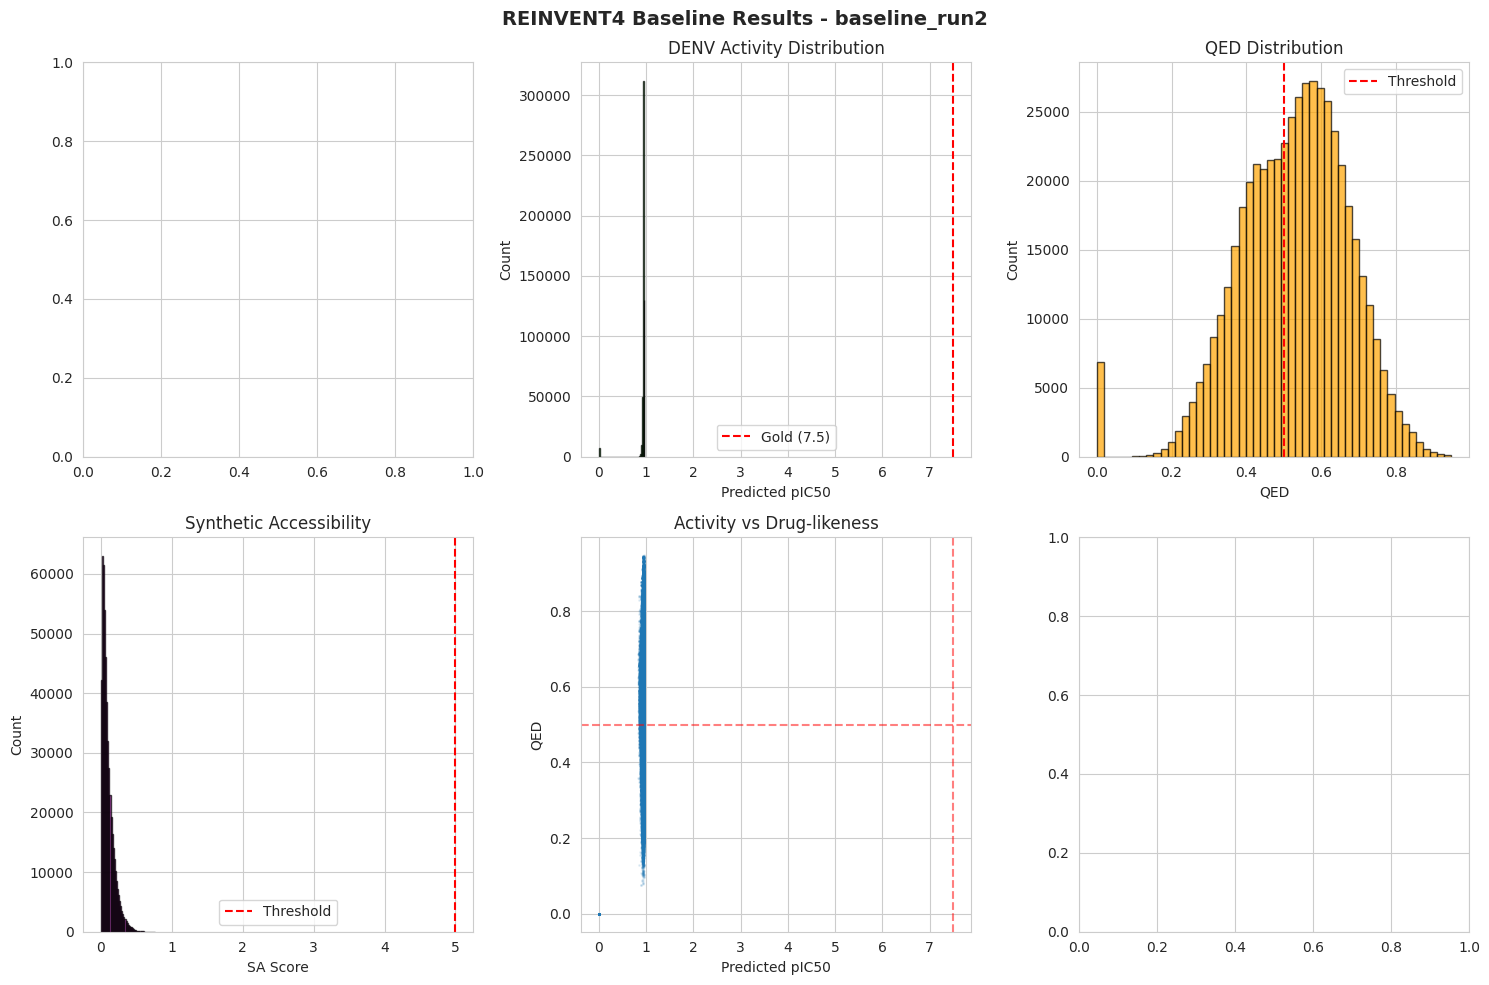

In [24]:
# Cell 10: 可视化分析
print("=" * 80)
print("可视化分析")
print("=" * 80)

if 'df' in dir() and len(df) > 0:
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'REINVENT4 Baseline Results - {EXP_NAME}', fontsize=14, fontweight='bold')
    
    # 1. Total Score分布
    if 'total_score' in df.columns:
        axes[0, 0].hist(df['total_score'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].axvline(df['total_score'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["total_score"].mean():.3f}')
        axes[0, 0].set_xlabel('Total Score')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title('Total Score Distribution')
        axes[0, 0].legend()
    
    # 2. DENV Activity分布
    if 'DENV_Activity' in df.columns:
        axes[0, 1].hist(df['DENV_Activity'], bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[0, 1].axvline(7.5, color='red', linestyle='--', label='Gold (7.5)')
        axes[0, 1].set_xlabel('Predicted pIC50')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('DENV Activity Distribution')
        axes[0, 1].legend()
    
    # 3. QED分布
    if 'QED' in df.columns:
        axes[0, 2].hist(df['QED'], bins=50, edgecolor='black', alpha=0.7, color='orange')
        axes[0, 2].axvline(0.5, color='red', linestyle='--', label='Threshold')
        axes[0, 2].set_xlabel('QED')
        axes[0, 2].set_ylabel('Count')
        axes[0, 2].set_title('QED Distribution')
        axes[0, 2].legend()
    
    # 4. SA Score分布
    if 'SA' in df.columns:
        axes[1, 0].hist(df['SA'], bins=50, edgecolor='black', alpha=0.7, color='purple')
        axes[1, 0].axvline(5.0, color='red', linestyle='--', label='Threshold')
        axes[1, 0].set_xlabel('SA Score')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Synthetic Accessibility')
        axes[1, 0].legend()
    
    # 5. pIC50 vs QED
    if 'DENV_Activity' in df.columns and 'QED' in df.columns:
        axes[1, 1].scatter(df['DENV_Activity'], df['QED'], alpha=0.1, s=1)
        axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].axvline(7.5, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Predicted pIC50')
        axes[1, 1].set_ylabel('QED')
        axes[1, 1].set_title('Activity vs Drug-likeness')
    
    # 6. 训练进度
    if 'step' in df.columns and 'total_score' in df.columns:
        step_stats = df.groupby('step')['total_score'].agg(['mean', 'std'])
        axes[1, 2].plot(step_stats.index, step_stats['mean'], linewidth=2)
        axes[1, 2].fill_between(step_stats.index, 
                                step_stats['mean'] - step_stats['std'],
                                step_stats['mean'] + step_stats['std'], alpha=0.3)
        axes[1, 2].set_xlabel('Training Step')
        axes[1, 2].set_ylabel('Mean Total Score')
        axes[1, 2].set_title('Training Progress')
    
    plt.tight_layout()
    plot_path = EXP_DIR / "baseline_analysis.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ 图表已保存: {plot_path.name}")
    plt.show()
else:
    print("\n⚠️ 没有数据可供可视化")

In [25]:
# Cell 11: 金标准候选提取
print("=" * 80)
print("金标准候选分子提取")
print("=" * 80)

if 'df' in dir() and len(df) > 0:
    # 金标准阈值
    thresholds = {
        'SMILES_state': 1,     # Valid
        'DENV_Activity': 7.0,  # pIC50 ≥ 7.0 (IC50 < 100nM)
        'QED': 0.5,
        'SA': 5.5,
        'total_score': 0.6,
    }
    
    print(f"\n金标准阈值:")
    for k, v in thresholds.items():
        print(f"  {k}: {v}")
    
    # 筛选
    mask = pd.Series([True] * len(df))
    for col, thresh in thresholds.items():
        if col in df.columns:
            if col == 'SA':  # SA越低越好
                mask &= (df[col] <= thresh)
            else:
                mask &= (df[col] >= thresh)
    
    gold_df = df[mask].copy()
    print(f"\n符合条件: {len(gold_df):,}")
    
    if len(gold_df) > 0 and 'SMILES' in gold_df.columns:
        gold_df_unique = gold_df.drop_duplicates(subset=['SMILES'])
        print(f"去重后: {len(gold_df_unique):,}")
        
        # 保存
        gold_output = EXP_DIR / "gold_candidates.csv"
        gold_df_unique.to_csv(gold_output, index=False)
        print(f"\n✅ 已保存: {gold_output.name}")
        
        # 显示Top 10
        print("\nTop 10 候选 (按pIC50排序):")
        top10 = gold_df_unique.nlargest(10, 'DENV_Activity')
        display_cols = ['SMILES', 'DENV_Activity', 'QED', 'SA', 'total_score']
        display_cols = [c for c in display_cols if c in top10.columns]
        print(top10[display_cols].to_string(index=False))
    else:
        print("\n⚠️ 未找到符合金标准的分子")
else:
    print("\n⚠️ 没有数据")

金标准候选分子提取

金标准阈值:
  SMILES_state: 1
  DENV_Activity: 7.0
  QED: 0.5
  SA: 5.5
  total_score: 0.6

符合条件: 0

⚠️ 未找到符合金标准的分子


In [26]:
# Cell 12: 实验总结
print("=" * 80)
print("Baseline实验总结")
print("=" * 80)

summary = f"""
实验名称: {EXP_NAME}
完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

配置参数:
  batch_size:    {BATCH_SIZE}
  sigma:         {SIGMA}
  learning_rate: {LEARNING_RATE}
  bucket_size:   {BUCKET_SIZE}
  max_steps:     {MAX_STEPS}

结果文件:
  {EXP_DIR}/
  ├── config.toml
  ├── results_1.csv
  ├── gold_candidates.csv
  ├── baseline_analysis.png
  ├── training.log
  └── tensorboard/

下一步实验建议:
  1. High Explore: sigma=200, rate=0.00005, bucket_size=10
  2. Fast Converge: sigma=80, rate=0.0002, bucket_size=30
  3. 根据Baseline结果调整权重
"""

print(summary)

# 保存总结
summary_path = EXP_DIR / "SUMMARY.txt"
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"\n✅ 总结已保存: {summary_path.name}")

Baseline实验总结

实验名称: baseline_run2
完成时间: 2025-12-02 09:37:58

配置参数:
  batch_size:    64
  sigma:         200
  learning_rate: 0.0002
  bucket_size:   20
  max_steps:     500

结果文件:
  /home/august/aidd/DENV_Drug_Discovery/experiments/runs/baseline_run2/
  ├── config.toml
  ├── results_1.csv
  ├── gold_candidates.csv
  ├── baseline_analysis.png
  ├── training.log
  └── tensorboard/

下一步实验建议:
  1. High Explore: sigma=200, rate=0.00005, bucket_size=10
  2. Fast Converge: sigma=80, rate=0.0002, bucket_size=30
  3. 根据Baseline结果调整权重


✅ 总结已保存: SUMMARY.txt
